CV HW2 

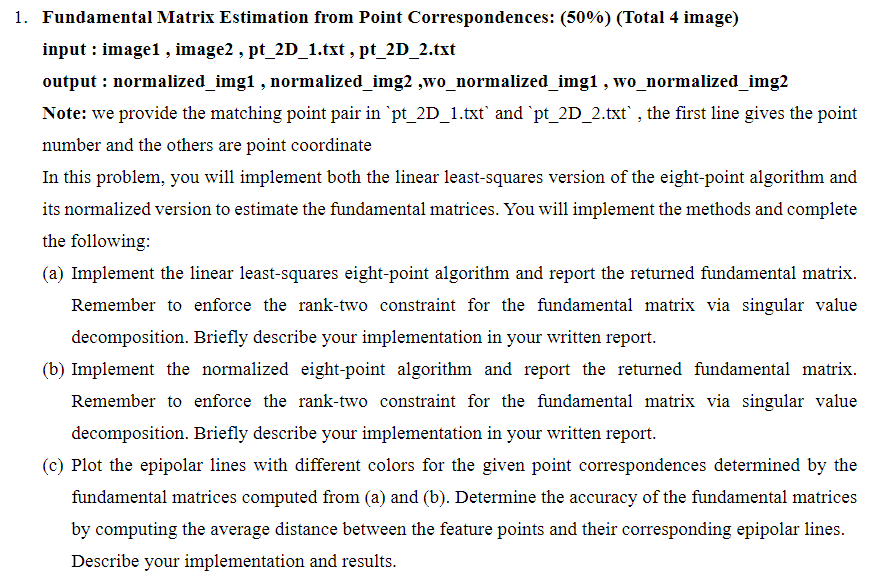

Fundamental Matrix_1(linear least-squares eight-point algorithm):
 [[ 5.73049326e-07  1.84327464e-06 -3.95701348e-04]
 [ 3.49597439e-06  1.02107317e-06  5.43635720e-03]
 [-2.91702511e-03 -8.06198319e-03  1.00000000e+00]]
Fundamental Matrix_2(linear least-squares eight-point algorithm):
 [[ 5.73049326e-07  3.49597439e-06 -2.91702511e-03]
 [ 1.84327464e-06  1.02107317e-06 -8.06198319e-03]
 [-3.95701348e-04  5.43635720e-03  1.00000000e+00]]


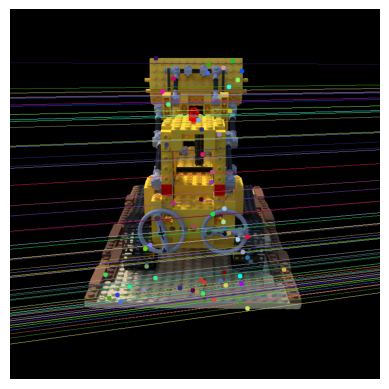

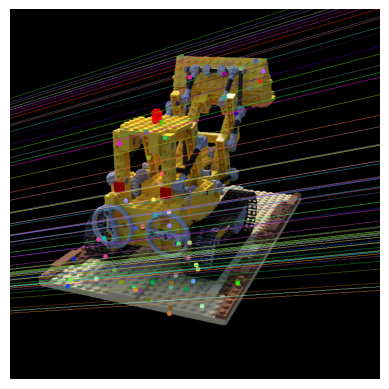

Fundamental Matrix_1(normalized eight-point algorithm):
 [[ 1.81998428e-06  9.69913460e-06  4.38365816e-03]
 [ 1.63733902e-05 -6.54630100e-07  7.50487446e-02]
 [-7.35508423e-03 -8.53995148e-02  1.00000000e+00]]
Fundamental Matrix_2(normalized eight-point algorithm):
 [[ 1.53459772e-07  1.38059255e-06 -5.99574200e-04]
 [ 8.17824088e-07 -5.51979416e-08 -8.11009829e-03]
 [ 2.59898308e-04  5.37790972e-03  1.00000000e+00]]
Average Distance for Fundamental Matrix 1 (without normalization): 42.17547210858556
Average Distance for Fundamental Matrix 2 (without normalization): 25.647718467962523
Average Distance for Normalized Fundamental Matrix 1: 19.392946358701874
Average Distance for Normalized Fundamental Matrix 2: 36.01864763451386


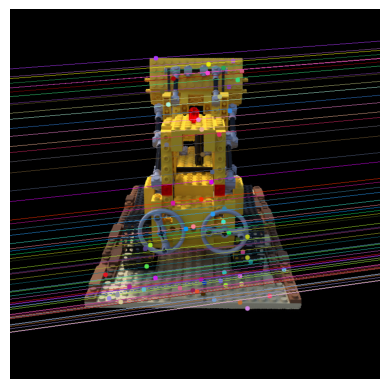

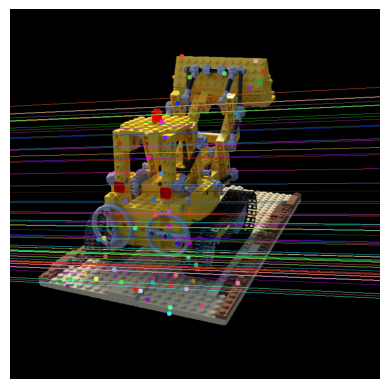

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

def read_point(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # the first row is a number, which means the number of points
    num_points = int(lines[0])
    # read each row after the first row
    points = [list(map(float, line.split())) for line in lines[1:]]
    return num_points, np.array(points)

def linear_least_squares_1(points1, points2, num_points):
    # linear least square eight-point algorithm
    A = np.zeros((num_points, 9))

    for i in range(num_points):
        x1, y1 = points1[i]
        x2, y2 = points2[i]
        A[i] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]

    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    U,S,V = np.linalg.svd(F)
    # enforce the rank-two constraint
    S[2] = 0
    # fundamental matrix
    F = np.dot(U,np.dot(np.diag(S),V))
    return F/F[2,2]

def linear_least_squares_2(points1, points2, num_points):
    A = np.zeros((num_points, 9))

    for i in range(num_points):
        x1, y1 = points1[i]
        x2, y2 = points2[i]
        # change!
        A[i] = [x1 * x2, y1 * x2, x2, x1 * y2, y1 * y2, y2, x1, y1, 1]

    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U,np.dot(np.diag(S),V))
    return F/F[2,2]

def normalized(points1, points2,num_points):
    # normalized eight-point algorithm
    mean_a = np.mean(points1[:, 0])
    mean_b = np.mean(points1[:, 1])
    # central point
    t = np.array([mean_a, mean_b])
    # distance between central point and each point
    min_dis1 = np.zeros((num_points,1))

    for p in range(num_points):
        x1, y1 = points1[p]  
        min_dis1[p] = np.sqrt((x1-t[0])**2 + (y1-t[1])**2)

    # average minimum distance
    mean_dist_1 = np.mean(min_dis1)
    S1 = np.sqrt(2)/mean_dist_1
    # find T
    T1 = np.array([[S1,0,-S1*t[0]],[0,S1,-S1*t[1]],[0,0,1]])
    # find new points
    points1_after_norm = np.zeros((num_points,2))

    for i in range(num_points):
        x1, y1 = points1[i]  
        points1_after = np.dot(T1, [x1, y1, 1])  
        points1_after_norm[i] = (points1_after[0], points1_after[1])  

    mean_c = np.mean(points2[:, 0])
    mean_d = np.mean(points2[:, 1])
    t2 = np.array([mean_c, mean_d])
    min_dis2 = np.zeros((num_points,1))

    for l in range(num_points):
        x2, y2 = points2[l]  
        min_dis2[l] = np.sqrt((x2-t[0])**2 + (y2-t[1])**2)
        
    mean_dist_2 = np.mean(min_dis2)
    S2 = np.sqrt(2)/mean_dist_2
    T2 = np.array([[S2,0,-S2*t2[0]],[0,S2,-S2*t2[1]],[0,0,1]])

    points2_after_norm = np.zeros((num_points,2))
    for j in range(num_points):
        x2, y2 = points2[j]  
        points2_after = np.dot(T2, [x2, y2, 1])  
        points2_after_norm[j] = (points2_after[0], points2_after[1]) 

    # use new points to compute fundamental matrix
    F1 = linear_least_squares_1(points1_after_norm, points2_after_norm, num_points)
    F2 = linear_least_squares_2(points1_after_norm, points2_after_norm, num_points)
    # output T^TFT'
    F1 = np.dot(T1.T,np.dot(F1,T2))
    F2 = np.dot(T1.T,np.dot(F2,T2))
    return F1/F1[2,2], F2/F2[2,2], points1_after_norm, points2_after_norm


def plot_epipolar_lines(F, img, points):
    # compute two points of one line
    for point in points:
        x, y = point

        point_homogeneous = np.array([x, y, 1])
        epipolar_line = np.dot(F, point_homogeneous)
        # the begin point of epipolar line
        x0, y0 = map(int, [0, -epipolar_line[2] / epipolar_line[1]])
        # the final point of epipolar line
        x1, y1 = map(int, [img.shape[1], -(epipolar_line[0] * img.shape[1] + epipolar_line[2]) / epipolar_line[1]])
        
        # plot the epipolar lines with different colors
        color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
        cv2.line(img, (x0, y0), (x1, y1), color, 1)
        # plot the points
        cv2.circle(img, (int(x), int(y)), 5, color, -1)

    return img

def calculate_average_distance(F, points1, points2):
    num_points = points1.shape[0]
    distances = []

    for i in range(num_points):
        x1, y1 = points1[i]
        x2, y2 = points2[i]

        # compute the epipolar line
        epipolar_line = np.dot(F, [x1, y1, 1])

        # calculate the distance from a point to its corresponding epipolar line
        distance = np.abs(np.dot(epipolar_line, [x2, y2, 1])) / np.sqrt(epipolar_line[0] ** 2 + epipolar_line[1] ** 2)
        distances.append(distance)

    # calculate the average distance
    average_distance = np.mean(distances)
    return average_distance

# input the position of the points
num_points, points1 = read_point("pt_2D_1.txt")
num_points_2, points2 = read_point("pt_2D_2.txt")

fundamental_matrix_1 = linear_least_squares_1(points1, points2, num_points)
print("Fundamental Matrix_1(linear least-squares eight-point algorithm):\n", fundamental_matrix_1)

fundamental_matrix_2 = linear_least_squares_2(points1, points2, num_points)
print("Fundamental Matrix_2(linear least-squares eight-point algorithm):\n", fundamental_matrix_2)

# input images
img1 = cv2.imread("image1.jpg")
img2 = cv2.imread("image2.jpg")

# use the copy one to avoid error
img1_copy = img1.copy()
img2_copy = img2.copy()
img1_copy_norm = img1.copy()
img2_copy_norm = img2.copy()

wo_normalized_img1 = plot_epipolar_lines(fundamental_matrix_1, img1_copy, points1)
plt.figure()
plt.imshow(cv2.cvtColor(wo_normalized_img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

wo_normalized_img2 = plot_epipolar_lines(fundamental_matrix_2, img2_copy, points2)
plt.figure()
plt.imshow(cv2.cvtColor(wo_normalized_img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

fundamental_matrix_norm_1, fundamental_matrix_norm_2, points1_after, points2_after = normalized(points1,points2,num_points)
print("Fundamental Matrix_1(normalized eight-point algorithm):\n", fundamental_matrix_norm_1)
print("Fundamental Matrix_2(normalized eight-point algorithm):\n", fundamental_matrix_norm_2)

average_distance_1 = calculate_average_distance(fundamental_matrix_1, points1, points2)
average_distance_2 = calculate_average_distance(fundamental_matrix_2, points1, points2)
average_distance_norm_1 = calculate_average_distance(fundamental_matrix_norm_1, points1, points2)
average_distance_norm_2 = calculate_average_distance(fundamental_matrix_norm_2, points1, points2)

print("Average Distance for Fundamental Matrix 1 (without normalization):", average_distance_1)
print("Average Distance for Fundamental Matrix 2 (without normalization):", average_distance_2)
print("Average Distance for Normalized Fundamental Matrix 1:", average_distance_norm_1)
print("Average Distance for Normalized Fundamental Matrix 2:", average_distance_norm_2)

normalized_img1 = plot_epipolar_lines(fundamental_matrix_norm_1, img1_copy_norm, points1)
plt.figure()
plt.imshow(cv2.cvtColor(normalized_img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
normalized_img2 = plot_epipolar_lines(fundamental_matrix_norm_2, img2_copy_norm, points2)
plt.figure()
plt.imshow(cv2.cvtColor(normalized_img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

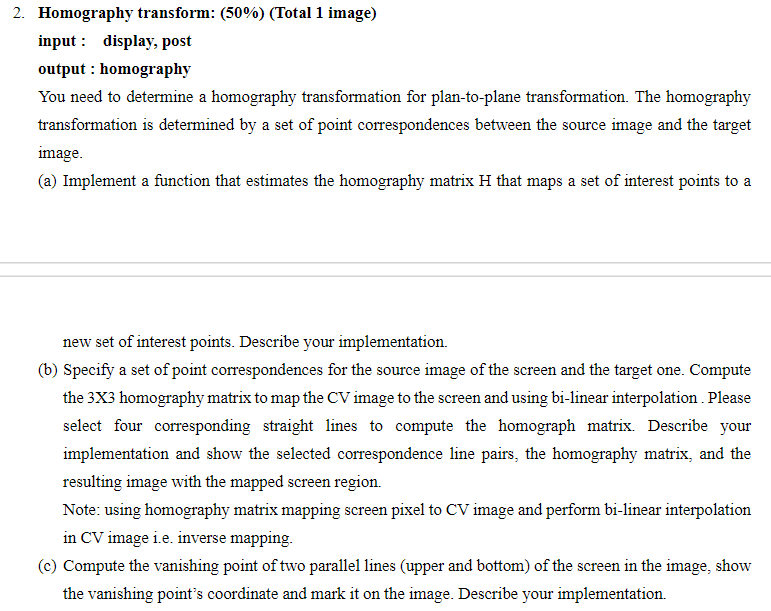

Click on four corners of the computer screen and then press ENTER
homography matrix:
 [[2.11473462e+00 1.45265472e-02 5.43000000e+02]
 [6.46214697e-01 1.61832212e+00 1.17000000e+02]
 [1.25681446e-03 2.32478823e-05 1.00000000e+00]]
Selected correspondence pair 1 (source -> destination):
Source point: [0. 0.] -> Destination point: [543. 117.]
Selected correspondence pair 2 (source -> destination):
Source point: [799.   0.] -> Destination point: [1114.  316.]
Selected correspondence pair 3 (source -> destination):
Source point: [799. 532.] -> Destination point: [1111.  741.]
Selected correspondence pair 4 (source -> destination):
Source point: [  0. 532.] -> Destination point: [544. 966.]
homography matrix in (b):
 [[ 6.98472099e-01 -8.22699731e-04 -3.79174094e+02]
 [-2.15804685e-01  6.19218467e-01  4.47333832e+01]
 [-8.72832834e-04 -1.33615372e-05  1.47551153e+00]]


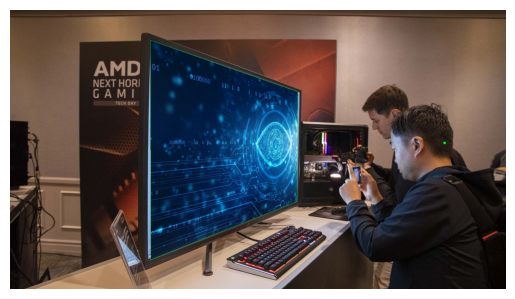

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# determine interest four points(order: upper left, upper right, bottom right, bottom left)
def mouse_handler(event, x, y, flags, data):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(data['im'], (x, y), 3, (0, 0, 255), 5, 16)
        cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
        cv2.imshow("Image", data['im'])

        if len(data['points']) < 4:
            data['points'].append([x, y])

# get the coordinates of points
def get_four_points(im):
    data = {}
    data['im'] = im.copy()
    data['points'] = []

    cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
    cv2.imshow('Image', im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    points = np.array(data['points'], dtype=np.float32)
    return points

def calculate_homography_matrix(src, dst):
    A = np.zeros((8, 9))

    for i in range(4):
        x, y = src[i, 0], src[i, 1]  # source points (x, y)
        u, v = dst[i, 0], dst[i, 1]  # destination points (u, v)
        A[2 * i] = [-x, -y, -1, 0, 0, 0, x * u, y * u, u]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, x * v, y * v, v]

    # SVD
    _, _, v = np.linalg.svd(A)
    h = v[-1, :].reshape(3, 3)
    h /= h[2, 2]
    return h

def inverse_warping(h, src_img, dst_size):
    # find the inverse of h
    h_inv = np.linalg.inv(h)
    print("homography matrix in (b):\n",h_inv)

    dst_img = np.zeros((dst_size[1], dst_size[0], 3), dtype=np.uint8)

    for y in range(dst_size[1]):
        for x in range(dst_size[0]):
            # inverse mapping
            p_dst = np.array([x, y, 1])
            p_src = np.dot(h_inv, p_dst)
            src_x, src_y, w = p_src / p_src[2]

            # bi-linear interpolation
            if 0 <= src_x < src_img.shape[1] - 1 and 0 <= src_y < src_img.shape[0] - 1:
                x0, y0 = int(src_x), int(src_y)
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = src_x - x0, src_y - y0

                pixel00 = src_img[y0, x0]
                pixel01 = src_img[y0, x1]
                pixel10 = src_img[y1, x0]
                pixel11 = src_img[y1, x1]

                mapped_pixel = (1 - dx) * (1 - dy) * pixel00 + dx * (1 - dy) * pixel01 + (1 - dx) * dy * pixel10 + dx * dy * pixel11

                dst_img[y, x] = mapped_pixel

    return dst_img

# input images
img_src = cv2.imread("post.png")
img_dst = cv2.imread("display.jpg")

# get user-selected points
print("Click on four corners of the computer screen and then press ENTER")
four_point = get_four_points(img_dst)

# define the source points
src_pts = np.array(
    [
        [0, 0],
        [img_src.shape[1] - 1, 0],
        [img_src.shape[1] - 1, img_src.shape[0] - 1],
        [0, img_src.shape[0] - 1]
    ],
    dtype=np.float32
)
# define the target points
dst_pts = four_point

# estimate the homography matrix
H = calculate_homography_matrix(src_pts, dst_pts)
print("homography matrix:\n",H)

# print the selected correspondence line pairs
for i in range(4):
    print(f"Selected correspondence pair {i + 1} (source -> destination):")
    print(f"Source point: {src_pts[i]} -> Destination point: {dst_pts[i]}")

# inverse warp the source image
size = (img_dst.shape[1], img_dst.shape[0])
warped_img = inverse_warping(H, img_src, size)

# composite the result image
mask = np.ones_like(img_dst)
cv2.fillConvexPoly(mask, four_point.astype(int), 0)
homography = img_dst.copy()
homography = homography * mask + warped_img

# calculate the cross product of two lines represented as homogeneous coordinates
top_line = np.cross(np.append(dst_pts[0], 1), np.append(dst_pts[1], 1))
bottom_line = np.cross(np.append(dst_pts[3], 1), np.append(dst_pts[2], 1))

# compute the vanishing point
v_point = np.cross(top_line, bottom_line)
v_point /= v_point[2]  # normalize the vanishing point
v_point_x, v_point_y = v_point[0], v_point[1]

# round to integer values
v_point_x, v_point_y = int(v_point_x), int(v_point_y)

# draw a circle at the vanishing point
cv2.circle(homography, (v_point_x, v_point_y), 5, (0, 255, 0), -1)

# draw four green lines
cv2.line(homography,(int(four_point[0,0]),int(four_point[0,1])),(int(four_point[1,0]),int(four_point[1,1])),(0,255,0),1)
cv2.line(homography,(int(four_point[1,0]),int(four_point[1,1])),(int(four_point[2,0]),int(four_point[2,1])),(0,255,0),1)
cv2.line(homography,(int(four_point[2,0]),int(four_point[2,1])),(int(four_point[3,0]),int(four_point[3,1])),(0,255,0),1)
cv2.line(homography,(int(four_point[3,0]),int(four_point[3,1])),(int(four_point[0,0]),int(four_point[0,1])),(0,255,0),1)

# show the result
plt.figure()
plt.imshow(cv2.cvtColor(homography, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
